## Segment raw HPA sample images into individual cells

In [1]:
import os
from typing import List

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hpacellseg.cellsegmentator import CellSegmentator
from hpacellseg.utils import label_cell

In [2]:
# Config
NUC_MODEL = "../notebooks/nuclei-model.pth"
CELL_MODEL = "../notebooks/cell-model.pth"
CHANNELS = ['red', 'yellow', 'blue', 'green']

In [3]:
def read_training_csv(csv_path):
    'Return dataframe containing ids and labels for training set images'
    train = pd.read_csv(csv_path)
    # One-hot encode label column
    def encoder(row):
        # Init vector of zeros
        encoded_label = [0] * 19
        labels = row['Label'].split('|')
        for label in labels:
            # Replace zeros with 1's based on labels present
            encoded_label[int(label)] = 1
        row['Label'] = encoded_label
        return row
    
    train = train.apply(encoder, axis=1)
    
    return train

def fetch_channels(img_id: str, dir_path: str, channel_names=CHANNELS) -> List[str]:
    'Return absolute path of segmentation channels of a given image id'
    base = os.path.join(dir_path, img_id)
    return [base + '_' + i  + '.png' for i in channel_names]

def get_segmentation_mask(ref_channels: List[str], segmentator: CellSegmentator):
    'Return cell segmentation mask for single image using paths to reference channels'
    # Ref channels must be in order red, yellow, blue
    input_ = [[i] for i in ref_channels]  # Segmentator only accepts list of lists input
    nuc_segmentation = segmentator.pred_nuclei(input_[2])[0]
    cell_segmentation = segmentator.pred_cells(input_)[0]
    mask = label_cell(nuc_segmentation, cell_segmentation)[1]
    return mask

def is_image_edge(img_shape, y_min, y_max, x_min, x_max):
    'Return true if cell bounding box is touching edge of parent image'
    if (y_min == 0) or (x_min == 0): 
        return True
    elif ((y_max + 1) >= img_shape[0]) or ((x_max + 1) >= img_shape[1]):
        return True
    else:
        return False

def record_metadata(array_img, cell_id, cell_num, parent_id, edge_of_image, df):
    'Return updated dataframe with image metadata'
    metadata = {'cell_id': cell_id,
                'parent_image_id': parent_id,
                'cell_number': cell_num,
                'size_y': array_img.shape[0],
                'size_x': array_img.shape[1],
                'edge_of_img': edge_of_image # is on the edge of parent image?
                }
    return df.append(metadata, ignore_index=True)
    
def save_img(destination_dir, filename, array_img):
    'Save numpy array to png file'
    path = os.path.join(destination_dir, filename)
    Image.fromarray(array_img).save(f'{path}.png')
    
def extract_and_save(parent_id, channels, mask, df, destination, visualise=False):
    'Save individual cells as channel images and record metadata in df'
    for label in np.unique(mask):
        # Get values from where image == label
        if label == 0:
            continue  # ignore background
        temp_mask = mask.copy()
        temp_mask[temp_mask != label] = 0
        temp_mask[temp_mask == label] = 1
        # Get temp mask bounding box coords
        idxs = np.asarray(temp_mask == 1).nonzero()
        y_min, y_max = idxs[0].min(), idxs[0].max()
        x_min, x_max = idxs[1].min(), idxs[1].max()
        edge_of_image = is_image_edge(temp_mask.shape, y_min, y_max, x_min, x_max)
        
        for channel in channels:
            channel_arr = np.array(Image.open(channel))
            channel_colour = channel.split('_')[-1][:-4]  # grab colour from end of channel path
            # Zero pad and square off
            single_cell = temp_mask * channel_arr
            single_cell = single_cell[y_min:(y_max + 1), x_min:(x_max + 1)]
            #plt.imshow(single_cell)
            cell_id = f'{parent_id}_cell_{label}'  # Overall cell id
            cell_channel_id = f'{cell_id}_{channel_colour}'  # Append colour channel when saving images
            save_img(destination, cell_channel_id, single_cell)
            
        df = record_metadata(single_cell, cell_id, label, parent_id, edge_of_image, df)
    
    return df

def segment_image(img_id, input_dir, output_dir, seg):
    'Segment cells in img_id and save these to a directory, return metadata on img'
    # arg pass the dir through from terminal
    channels = fetch_channels(img_id, input_dir)
    ref_channels = channels[:3]
    df = pd.DataFrame()
    
    mask = get_segmentation_mask(ref_channels, seg)
    df = extract_and_save(img_id, channels, mask, df, output_dir, visualise=False)
    
    return df

def run(input_dir, train_csv, output_dir, 
        NUC_MODEL="../notebooks/nuclei-model.pth", 
        CELL_MODEL="../notebooks/cell-model.pth"):
    'Run segment_image function on all images in training csv'
    # Init seg models
    seg = CellSegmentator(
        NUC_MODEL,
        CELL_MODEL,
        scale_factor=0.25,
        device="cuda",
        padding=False,  # RUN W/ PADDING=TRUE???
        multi_channel_model=True
        )
    # Get image ids and their targets from provided training csv
    train_df = read_training_csv(train_csv)
    output_df = pd.DataFrame()  # init output_df to record metadata
    # Iterate through each image_id in train.csv
    for count, img_id, target in train_df.itertuples():
        df = segment_image(img_id, input_dir, output_dir, seg)
        output_df = output_df.append(df)
        print(f'Image {count} processed!')
    
    # Append weak labels to cells in parent image 
    train_df.set_index('ID', inplace=True)
    output_df = output_df.join(train_df, on='parent_image_id')
    
    # Save new csv with segmented cell images
    output_df.reset_index(drop=True, inplace=True)
    output_df.to_csv(os.path.join(output_dir, 'train.csv'))
    return output_df

img_id = ID
dir_ = '../input/single_img'
dest_dir = '../output/segmented_cells' 
df = segment_image(img_id, dir_, dest_dir, seg)

In [4]:
input_dir = '../input/train_example'
train_csv = '../input/train_example/train.csv'
output_dir = '../input/train_cells'

df = run(input_dir, '../input/train_example/train.csv', output_dir)

please compile abn


C:\Users\micha\anaconda3\envs\cell\lib\site-packages\torch\serialization.py:656: SourceChangeWarning: source code of class 'pytorch_zoo.unet.DPNUnet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\micha\anaconda3\envs\cell\lib\site-packages\torch\serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\micha\anaconda3\envs\cell\lib\site-packages\torch\serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by acce

Image 0 processed!
Image 1 processed!
Image 2 processed!


In [5]:
df.head()

cell_id  cell_number  edge_of_img  \
0  5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_cell_1          1.0          0.0   
1  5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_cell_2          2.0          0.0   
2  5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_cell_3          3.0          1.0   
3  5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_cell_4          4.0          0.0   
4  5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_cell_5          5.0          0.0   

                        parent_image_id  size_x  size_y  \
0  5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0   248.0   236.0   
1  5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0   475.0   915.0   
2  5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0   602.0   184.0   
3  5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0   788.0   320.0   
4  5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0   696.0   394.0   

                                               Label  
0  [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...  
1  [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...  
2  [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...  
3  [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...  
4  [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...

In [6]:
df.tail()

cell_id  cell_number  edge_of_img  \
35  60b57878-bb99-11e8-b2b9-ac1f6b6435d0_cell_13         13.0          0.0   
36  60b57878-bb99-11e8-b2b9-ac1f6b6435d0_cell_14         14.0          1.0   
37  60b57878-bb99-11e8-b2b9-ac1f6b6435d0_cell_15         15.0          0.0   
38  60b57878-bb99-11e8-b2b9-ac1f6b6435d0_cell_16         16.0          1.0   
39  60b57878-bb99-11e8-b2b9-ac1f6b6435d0_cell_17         17.0          0.0   

                         parent_image_id  size_x  size_y  \
35  60b57878-bb99-11e8-b2b9-ac1f6b6435d0   142.0   167.0   
36  60b57878-bb99-11e8-b2b9-ac1f6b6435d0   242.0   220.0   
37  60b57878-bb99-11e8-b2b9-ac1f6b6435d0  1540.0   796.0   
38  60b57878-bb99-11e8-b2b9-ac1f6b6435d0   342.0   360.0   
39  60b57878-bb99-11e8-b2b9-ac1f6b6435d0   408.0   412.0   

                                                Label  
35  [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  
36  [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  
37  [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  
38  [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  
39  [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...

## Example segmentations...

In [7]:
def show_image(i_d, path='../input/train_cells/'):
    red    = Image.open(path+i_d+'_red.png').convert('L')
    green  = Image.open(path+i_d+'_green.png').convert('L')
    blue   = Image.open(path+i_d+'_blue.png').convert('L')
    yellow = Image.open(path+i_d+'_yellow.png').convert('L')
    rgb = Image.merge("RGB", (red, green, blue))
    return rgb

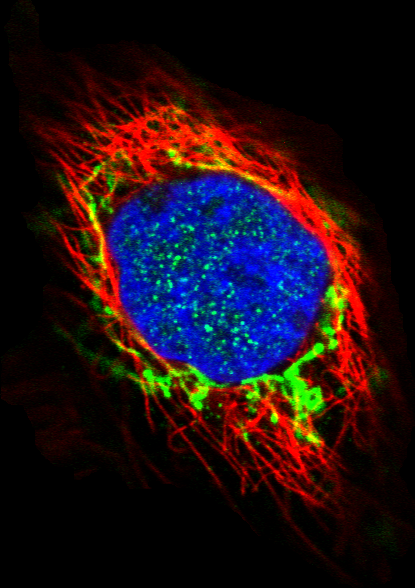

In [8]:
i_d = '5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0_cell_3'
show_image(i_d)

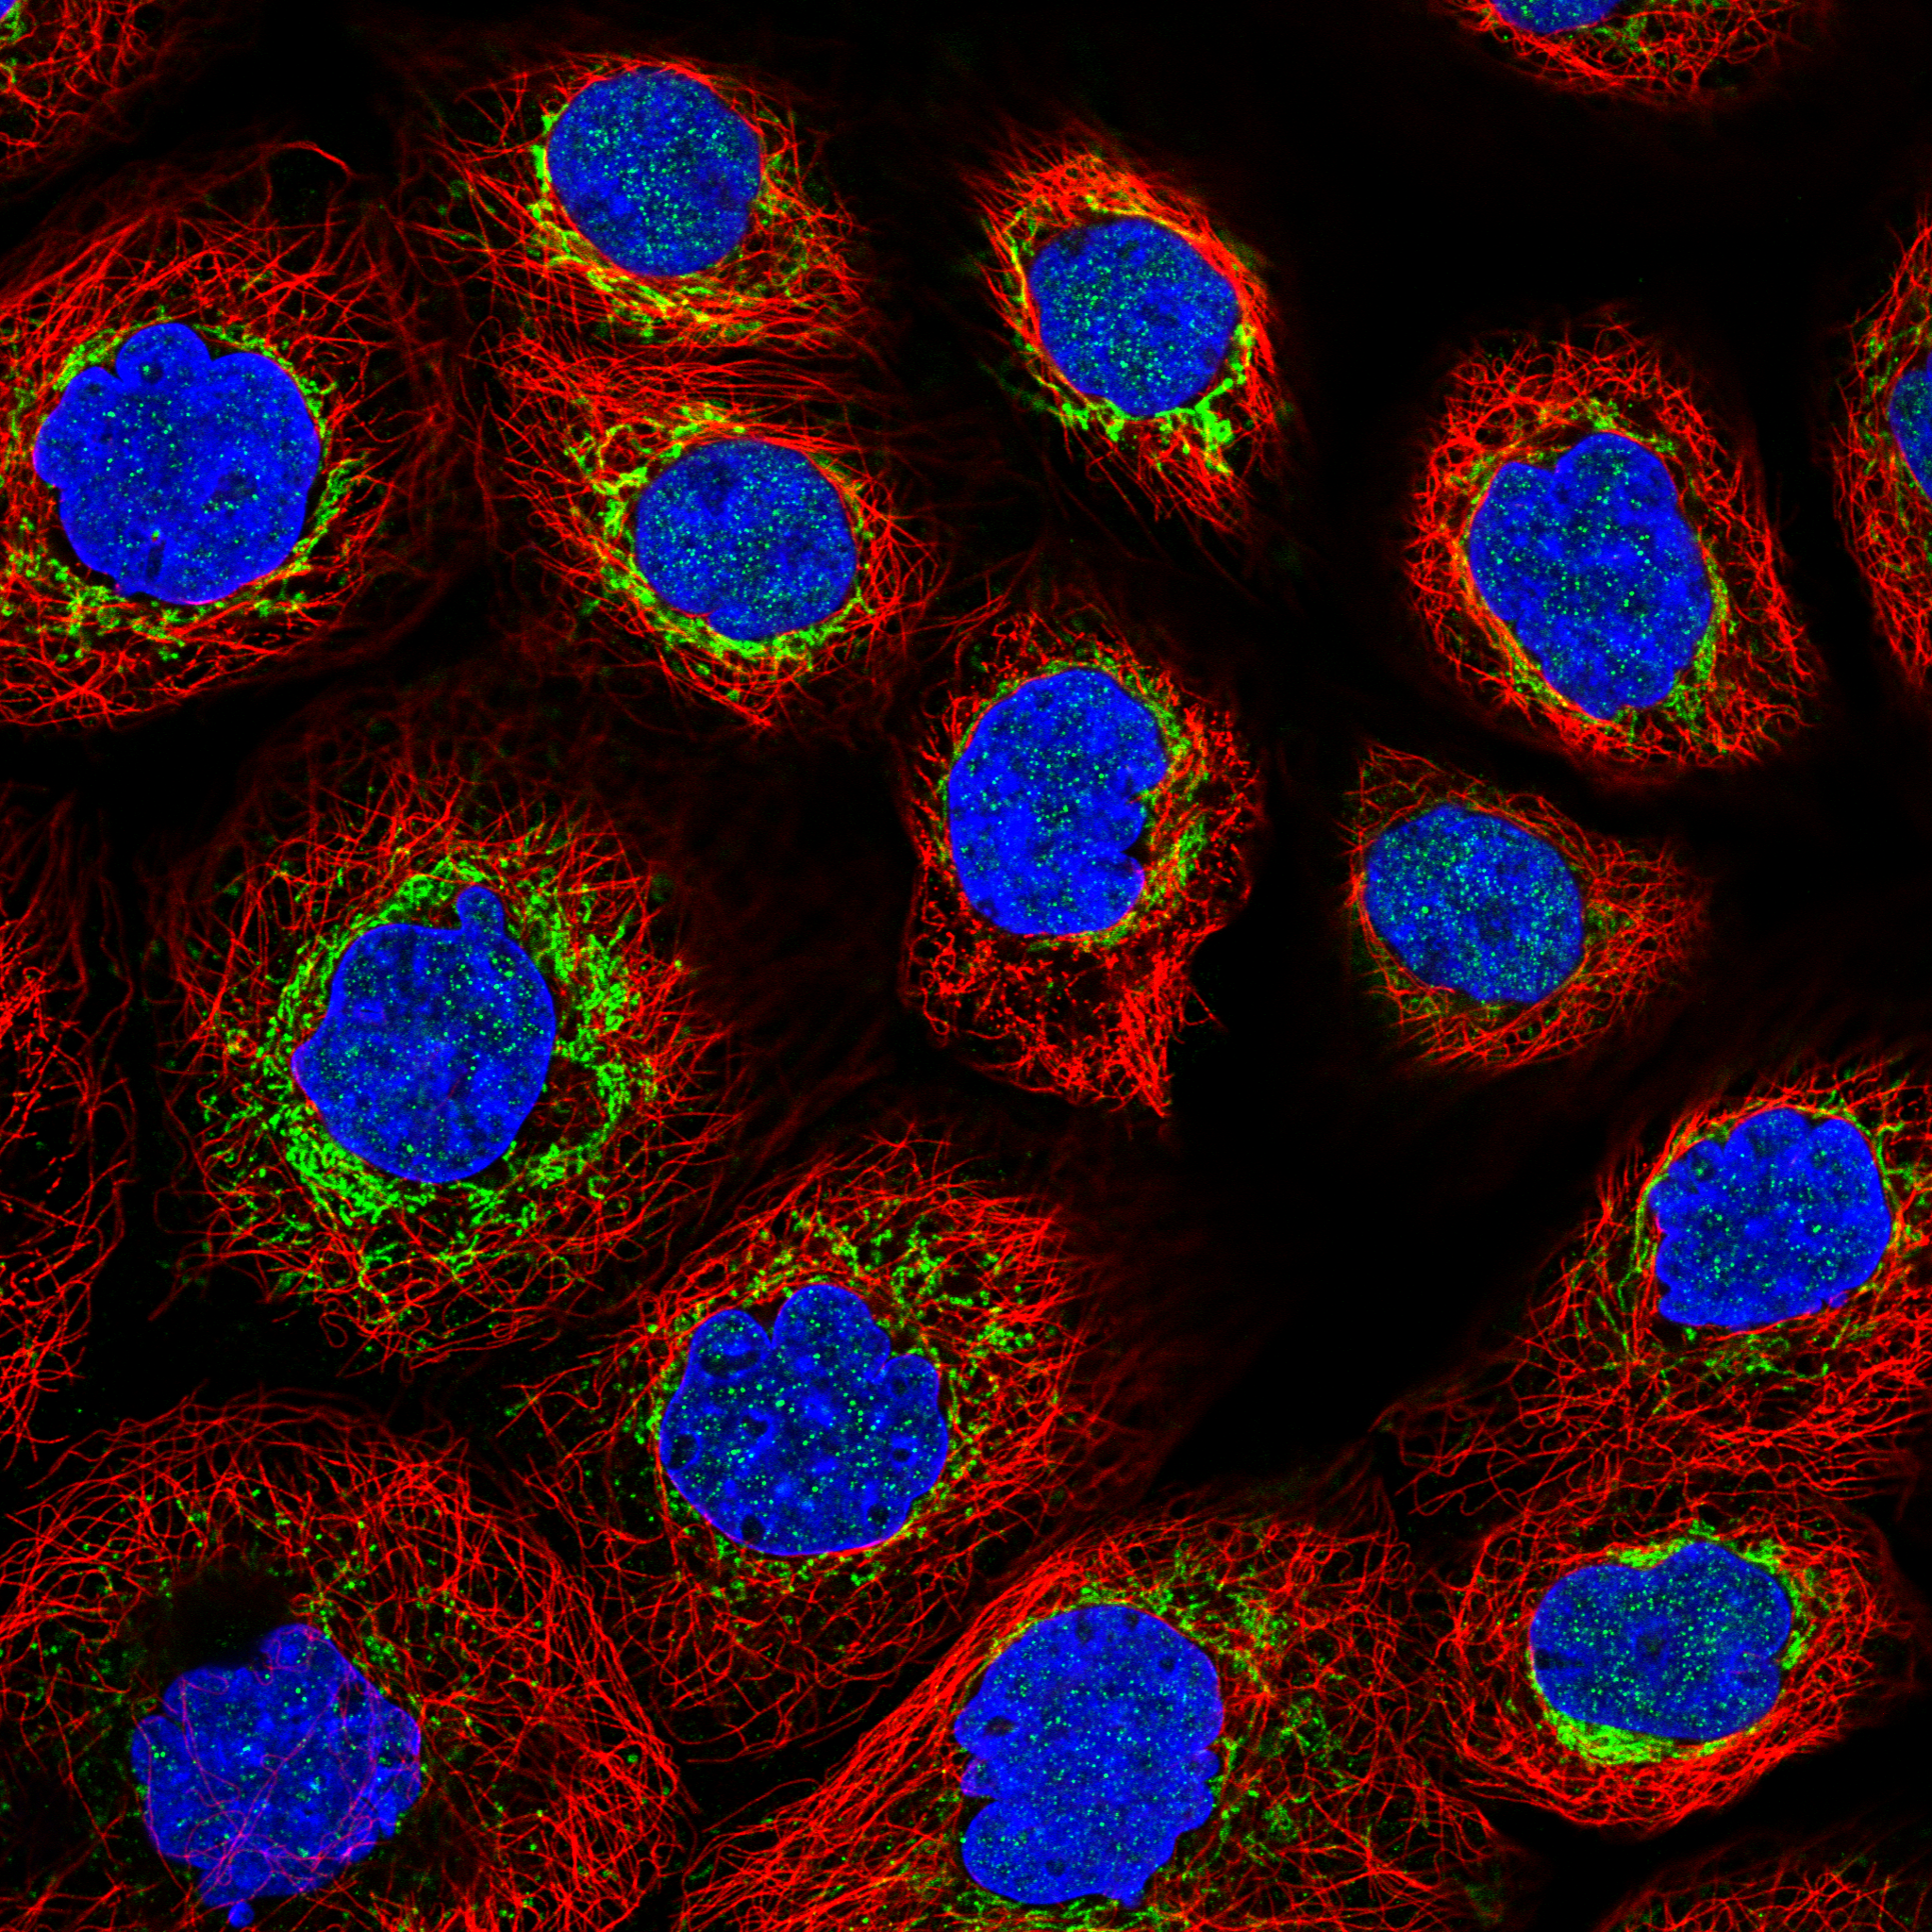

In [9]:
id_ = '5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0'
show_image(id_, path='../input/train_example/')